In [ ]:
import pennylane as qml
import pandas as pd
from qco_level_0 import *
from qco_level_1 import optimization_level_1
from qco_level_2 import optimization_level_2
from qco_spec_table import *
import seaborn as sns
import matplotlib.pyplot as plt
import time
from qiskit.transpiler import PassManager

In [3]:
[ds] = qml.data.load("ketgpt")

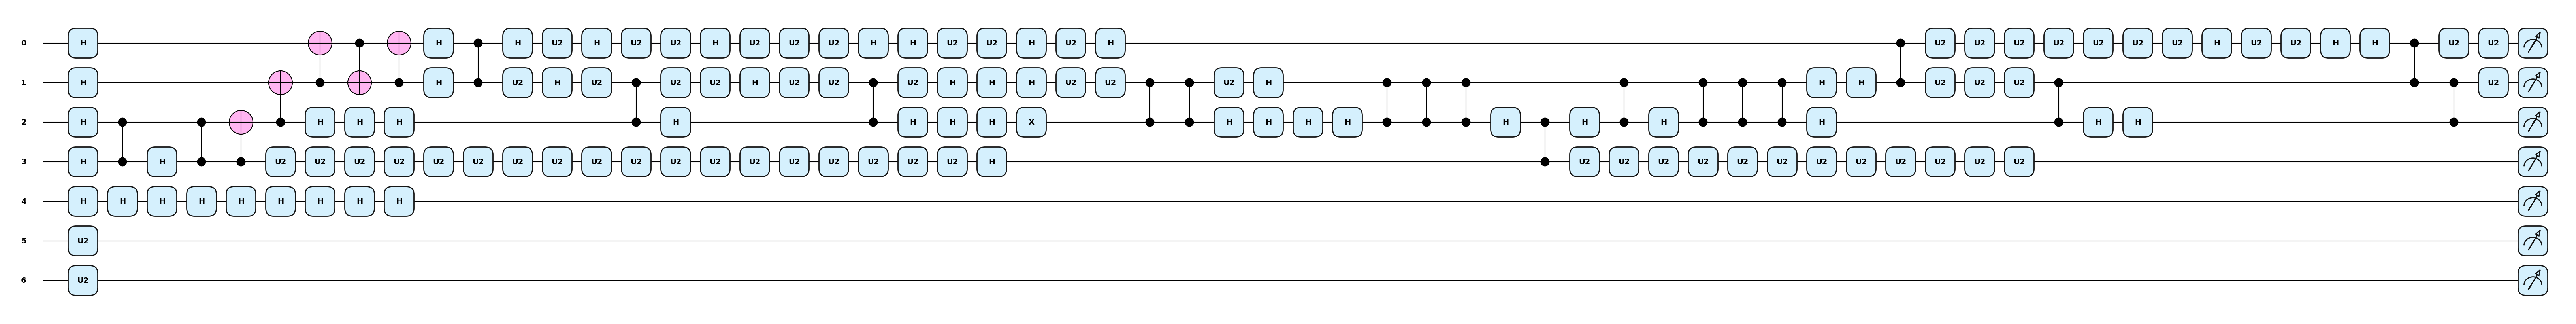

0.4504973888397217
0.0
0.11473560333251953


In [4]:
# example
seed = 27
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        qml.apply(op)
    return qml.state()

show_circuit(circuit)

time_q = []
time_p = []
time_m = []

# q
qc = to_qc(circuit)
qc = copy.deepcopy(qc)
start = time.time()
transpiled_qiskit = qiskit_transpiler(qc)
end = time.time()
print(end-start)

# p 
pipeline = [cancel_inverses, commute_controlled, merge_rotations, single_qubit_fusion, combine_global_phases]
start = time.time()
transpiled_penny = compile(circuit, pipeline=pipeline)
end = time.time()
print(end-start)

# m
start = time.time()
qnode_q1 = optimization_level_1(circuit)
qnode_q2 = optimization_level_2(qnode_q1)
qnode_q1 = optimization_level_1(qnode_q2)
end = time.time()
print(end-start)

In [ ]:
time_q = []
time_p = []
time_m = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            if op.name == 'QubitUnitary':
                continue
            qml.apply(op)
        return qml.state()
    try:
        # q
        qc = to_qc(circuit)
        pm = PassManager()
        pm.append([Optimize1qGates(), TemplateOptimization(), Collect2qBlocks()])
        start = time.time()
        transpiled_qiskit = pm.run(qc)
        end = time.time()
        time_q.append(end-start)

        # p 
        pipeline = [cancel_inverses, merge_rotations, single_qubit_fusion] 
        start = time.time()
        transpiled_penny = compile(circuit, pipeline=pipeline)
        end = time.time()
        time_p.append(end-start)

        # m
        start = time.time()
        qnode_q1 = optimization_level_1(circuit)
        qnode_q2 = optimization_level_2(qnode_q1)
        qnode_q1 = optimization_level_1(qnode_q2)
        end = time.time()
        time_m.append(end-start)
    except:
        pass

In [6]:
len(time_q)

1000

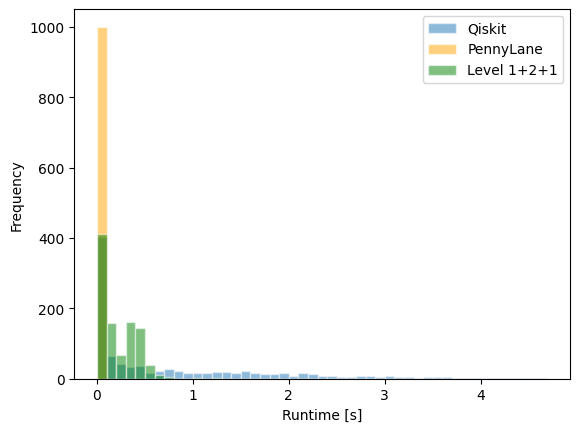

In [ ]:
plt.hist(time_q, bins=np.arange(0,4.8,0.1), edgecolor='white', alpha=0.5)
plt.hist(time_p,  bins=np.arange(0,4.8,0.1), edgecolor='white', color='orange', alpha=0.5)
plt.hist(time_m, bins=np.arange(0,4.8,0.1), edgecolor='white', color='green', alpha=0.5)
plt.xticks(np.arange(0,3.6,1))
plt.xlabel('Runtime [s]')
plt.ylabel('Frequency')
plt.legend(['Qiskit', 'PennyLane', 'Level 1+2+1'])
plt.show()

In [8]:
print(np.mean(time_q), np.mean(time_p), np.mean(time_m))

1.190633599281311 7.193064689636231e-05 0.21609591889381408
